In [1]:
import sys, os
BIN = os.path.expanduser("../../")
sys.path.append(BIN)

from __future__ import unicode_literals

import numpy as np
from scipy.constants import m_p, c, e
import matplotlib.pyplot as plt
%matplotlib inline

import copy
import itertools

from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.trackers.simple_long_tracking import LinearMap
from PyHEADTAIL.particles.particles import Particles
import PyHEADTAIL.particles.generators as generators
from PyHEADTAIL.particles.slicing import UniformBinSlicer, UniformChargeSlicer
from PyHEADTAIL_feedback.onebox_feedback import IdealBunchFeedback,IdealSliceFeedback,OneboxFeedback
from PyHEADTAIL_feedback.signal_processors import PhaseLinearizedLowpass, IdealSlice, IdealBunch,ChargeWeighting

np.random.seed(0)

PyHEADTAIL v1.8.0




In [2]:
def generate_bunch(n_macroparticles, alpha_x, alpha_y, beta_x, beta_y, linear_map):
    
    intensity = 1.05e11
    sigma_z = 0.059958
    gamma = 3730.26
    gamma_t = 1. / np.sqrt(alpha_0)
    p0 = np.sqrt(gamma**2 - 1) * m_p * c

    beta_z = (linear_map.eta(dp=0, gamma=gamma) * linear_map.circumference / 
              (2 * np.pi * linear_map.Qs))

    epsn_x = 3.75e-6 # [m rad]
    epsn_y = 3.75e-6 # [m rad]
    epsn_z = 4 * np.pi * sigma_z**2 * p0 / (beta_z * e) 
    
    bunch = generators.generate_Gaussian6DTwiss(
        macroparticlenumber=n_macroparticles, intensity=intensity, charge=e,
        gamma=gamma, mass=m_p, circumference=C,
        alpha_x=alpha_x, beta_x=beta_x, epsn_x=epsn_x,
        alpha_y=alpha_y, beta_y=beta_y, epsn_y=epsn_y,
        beta_z=beta_z, epsn_z=epsn_z)
    
    return bunch

In [3]:
def track_and_plot(n_turns, bunch_ref, map_ref, bunch_feedback, map_feedback):
    
    turn = np.empty(n_turns)
    
    mean_x_ref = np.empty(n_turns)
    mean_y_ref = np.empty(n_turns)
    sigma_x_ref = np.empty(n_turns)
    sigma_y_ref = np.empty(n_turns)
    epsn_x_ref = np.empty(n_turns)
    epsn_y_ref = np.empty(n_turns)
    
    mean_x_feedback = np.empty(n_turns)
    mean_y_feedback = np.empty(n_turns)
    sigma_x_feedback = np.empty(n_turns)
    sigma_y_feedback = np.empty(n_turns)
    epsn_x_feedback = np.empty(n_turns)
    epsn_y_feedback = np.empty(n_turns)
    
    for i in xrange(n_turns):
        
        turn[i] = i
        
        mean_x_ref[i] = bunch_ref.mean_x()
        mean_y_ref[i] = bunch_ref.mean_y()
        sigma_x_ref[i] = bunch_ref.sigma_x()
        sigma_y_ref[i] = bunch_ref.sigma_y()
        epsn_x_ref[i] = bunch_ref.epsn_x()
        epsn_y_ref[i] = bunch_ref.epsn_y()
        
        for m_ in map_ref:
            m_.track(bunch_ref)
        
        mean_x_feedback[i] = bunch_feedback.mean_x()
        mean_y_feedback[i] = bunch_feedback.mean_y()
        sigma_x_feedback[i] = bunch_feedback.sigma_x()
        sigma_y_feedback[i] = bunch_feedback.sigma_y()
        epsn_x_feedback[i] = bunch_feedback.epsn_x()
        epsn_y_feedback[i] = bunch_feedback.epsn_y()
        
        for i_ in map_feedback:
            i_.track(bunch_feedback)
            
    fig = plt.figure(figsize=(16, 16))
    ax_x_mean = fig.add_subplot(321)
    ax_x_sigma = fig.add_subplot(323)
    ax_x_epsn = fig.add_subplot(325)
    
    
    ax_x_mean.plot(turn, mean_x_ref*1000,'k-',turn, mean_x_feedback*1000,'b-')
    ax_x_mean.set_ylabel('<x> [mm]')
    ax_x_mean.ticklabel_format(useOffset=False)
    
    ax_x_sigma.plot(turn, sigma_x_ref*1000,'k-',turn, sigma_x_feedback*1000,'b-')
    ax_x_sigma.set_ylabel('sigma_x [mm]')
    ax_x_sigma.ticklabel_format(useOffset=False)
    
    ax_x_epsn.plot(turn, epsn_x_ref*1e6,'k-',turn, epsn_x_feedback*1e6,'b-')
    ax_x_epsn.set_ylabel('epsn_x [mm mrad]')
    ax_x_epsn.set_xlabel('Turn')
    ax_x_epsn.ticklabel_format(useOffset=False)
    
    ax_y_mean = fig.add_subplot(322)
    ax_y_sigma = fig.add_subplot(324)
    ax_y_epsn = fig.add_subplot(326)
    
    
    ax_y_mean.plot(turn, mean_y_ref*1000,'k-',turn, mean_y_feedback*1000,'r-')
    ax_y_mean.set_ylabel('<y> [mm]')
    ax_y_mean.ticklabel_format(useOffset=False)
    
    ax_y_sigma.plot(turn, sigma_y_ref*1000,'k-',turn, sigma_y_feedback*1000,'r-')
    ax_y_sigma.set_ylabel('sigma_y [mm]')
    ax_y_sigma.ticklabel_format(useOffset=False)
    
    ax_y_epsn.plot(turn, epsn_y_ref*1e6,'k-',turn, epsn_y_feedback*1e6,'r-')
    ax_y_epsn.set_ylabel('epsn_y  [mm mrad]')
    ax_y_epsn.set_xlabel('Turn')
    ax_y_epsn.ticklabel_format(useOffset=False)

    plt.show()

In [4]:
def plot_projections( bunch_ref, bunch_feedback):
    fig = plt.figure(figsize=(16, 5))
    ax_z_x = fig.add_subplot(121)
    ax_z_y = fig.add_subplot(122)
    
    ax_z_x.plot(bunch_ref.z,bunch_ref.x*1000,'k.',bunch_feedback.z,bunch_feedback.x*1000,'b.')
    ax_z_x.set_xlabel('z [m]')
    ax_z_x.set_ylabel('x [mm]')
    ax_z_y.plot(bunch_ref.z,bunch_ref.y*1000,'k.',bunch_feedback.z,bunch_feedback.y*1000,'r.')
    ax_z_y.set_xlabel('z [m]')
    ax_z_y.set_ylabel('y [mm]')

### Basic parameters

In [5]:
n_turns = 150
n_segments = 5
n_macroparticles = 1000

feedback_gain = 0.1

Q_x = 64.28
Q_y = 59.31
Q_s = 0.000000000001
#Q_s = 0.0020443

C = 26658.883
R = C / (2.*np.pi)

alpha_0 = [0.0003225]

### Transverse and longitunal maps

In [6]:
s = np.arange(0, n_segments + 1) * C / n_segments

alpha_x_inj = 0.
alpha_y_inj = 0.
beta_x_inj = 66.0064
beta_y_inj = 71.5376
    
alpha_x = alpha_x_inj * np.ones(n_segments)
beta_x = beta_x_inj * np.ones(n_segments)
D_x = np.zeros(n_segments)

alpha_y = alpha_y_inj * np.ones(n_segments)
beta_y = beta_y_inj * np.ones(n_segments)
D_y = np.zeros(n_segments)
        
trans_map = TransverseMap(s, alpha_x, beta_x, D_x, alpha_y, beta_y, D_y, Q_x, Q_y)
long_map = LinearMap(alpha_0, C, Q_s)

### Kicked bunch

In [7]:
bunch_ref = generate_bunch(n_macroparticles, alpha_x_inj, alpha_y_inj, beta_x_inj, beta_y_inj,long_map)

n_sigma_z = 3
n_slices = 15
slicer = UniformBinSlicer(n_slices=n_slices, n_sigma_z=n_sigma_z)

#initial kick
slice_set = bunch_ref.get_slices(slicer, statistics=True)
p_idx = slice_set.particles_within_cuts
s_idx = slice_set.slice_index_of_particle.take(p_idx)

#random kicks
kick_x = 0.003*(-1.0+2*np.random.rand(n_slices))
kick_y = 0.003*(-1.0+2*np.random.rand(n_slices))

for p_id, s_id in itertools.izip(p_idx,s_idx):
    bunch_ref.x[p_id] += kick_x[s_id]
    bunch_ref.y[p_id] += kick_y[s_id]

## Ideal bunch feedback

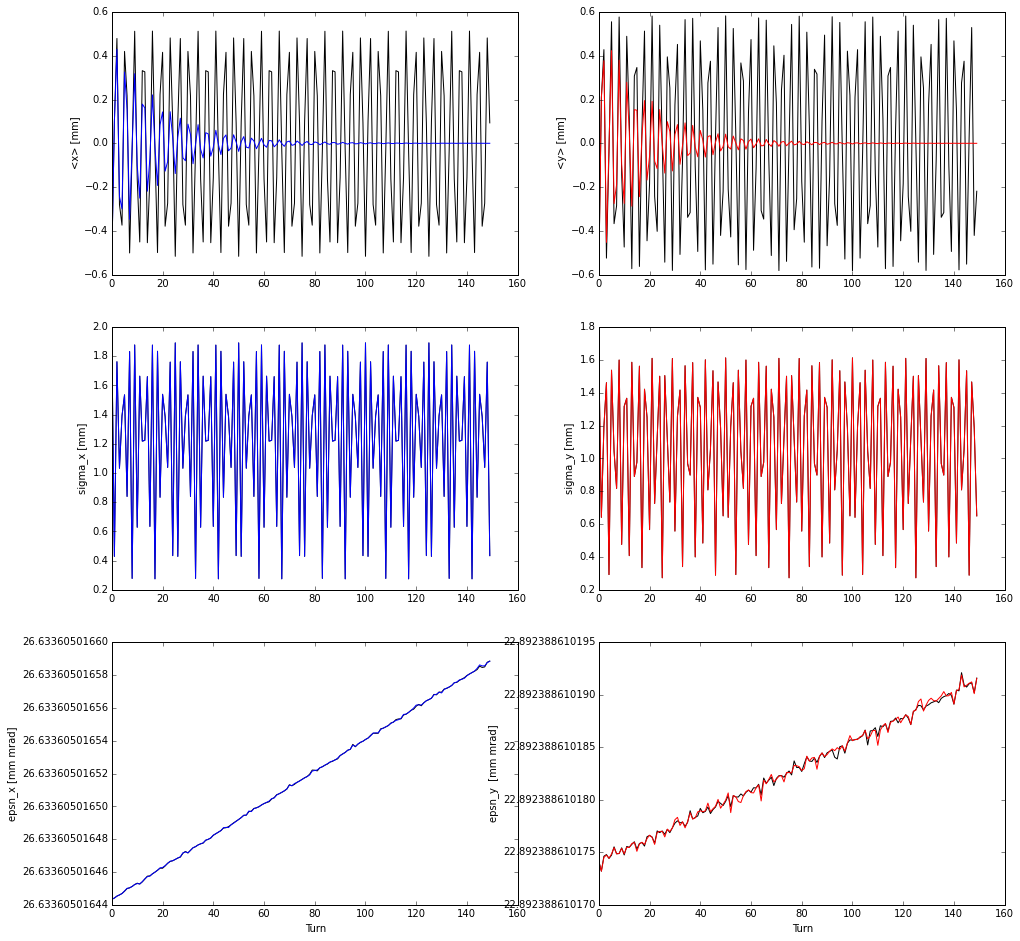

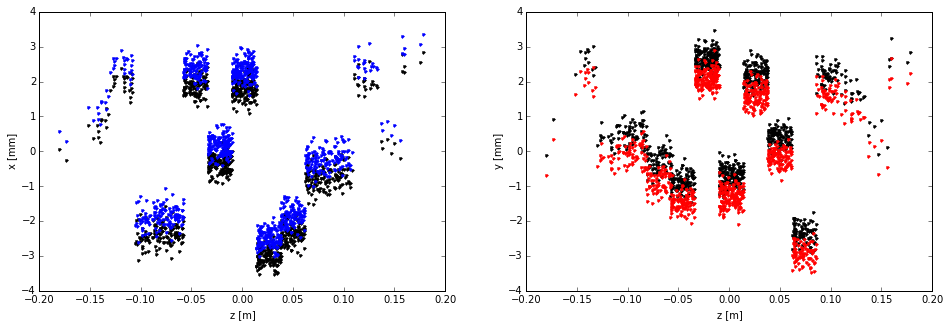

In [8]:
#Reference bunch
bunch_0 = copy.deepcopy(bunch_ref)
bunch_FB = copy.deepcopy(bunch_ref)

maps_ref = [i for i in trans_map] + [long_map]

feedback_map = IdealBunchFeedback(feedback_gain)
maps_feedback = [i for i in trans_map] + [long_map] + [feedback_map]

track_and_plot(n_turns, bunch_0, maps_ref, bunch_FB, maps_feedback)
plot_projections( bunch_0, bunch_FB)


## Ideal slice feedback

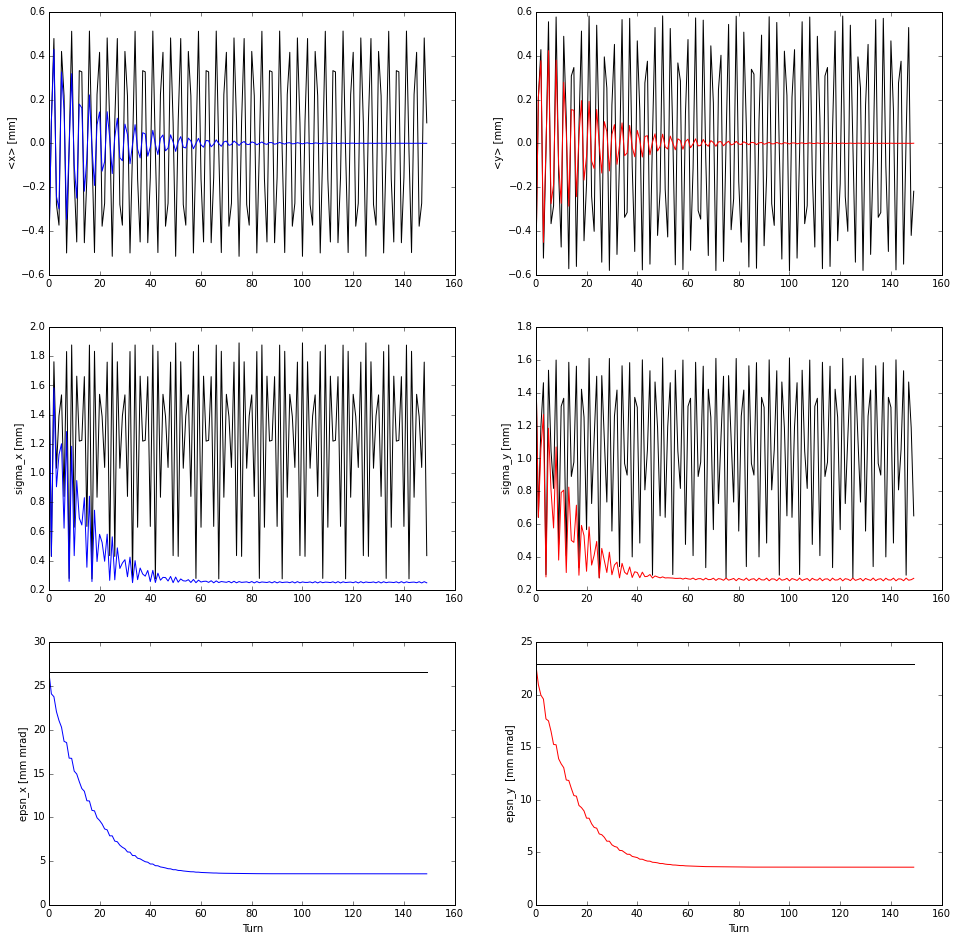

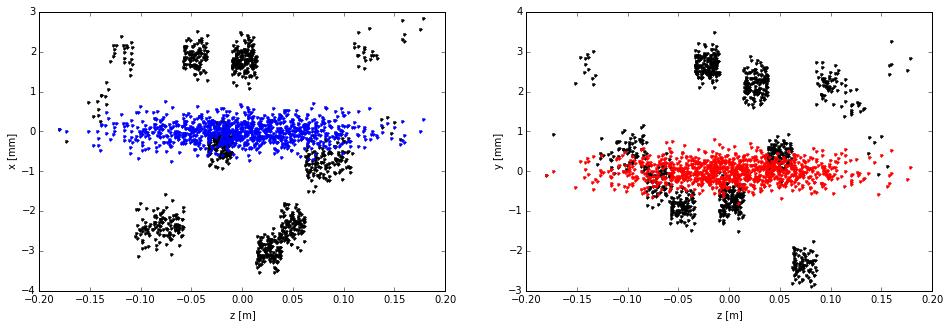

In [9]:
#Reference bunch
bunch_0 = copy.deepcopy(bunch_ref)
bunch_FB = copy.deepcopy(bunch_ref)

maps_ref = [i for i in trans_map] + [long_map]

feedback_map = IdealSliceFeedback(feedback_gain,slicer)
maps_feedback = [i for i in trans_map] + [long_map] + [feedback_map]

#plot_projections( bunch_0, bunch_FB)
track_and_plot(n_turns, bunch_0, maps_ref, bunch_FB, maps_feedback)
plot_projections( bunch_0, bunch_FB)


## Ideal slice feedback by using general Onebox feedback

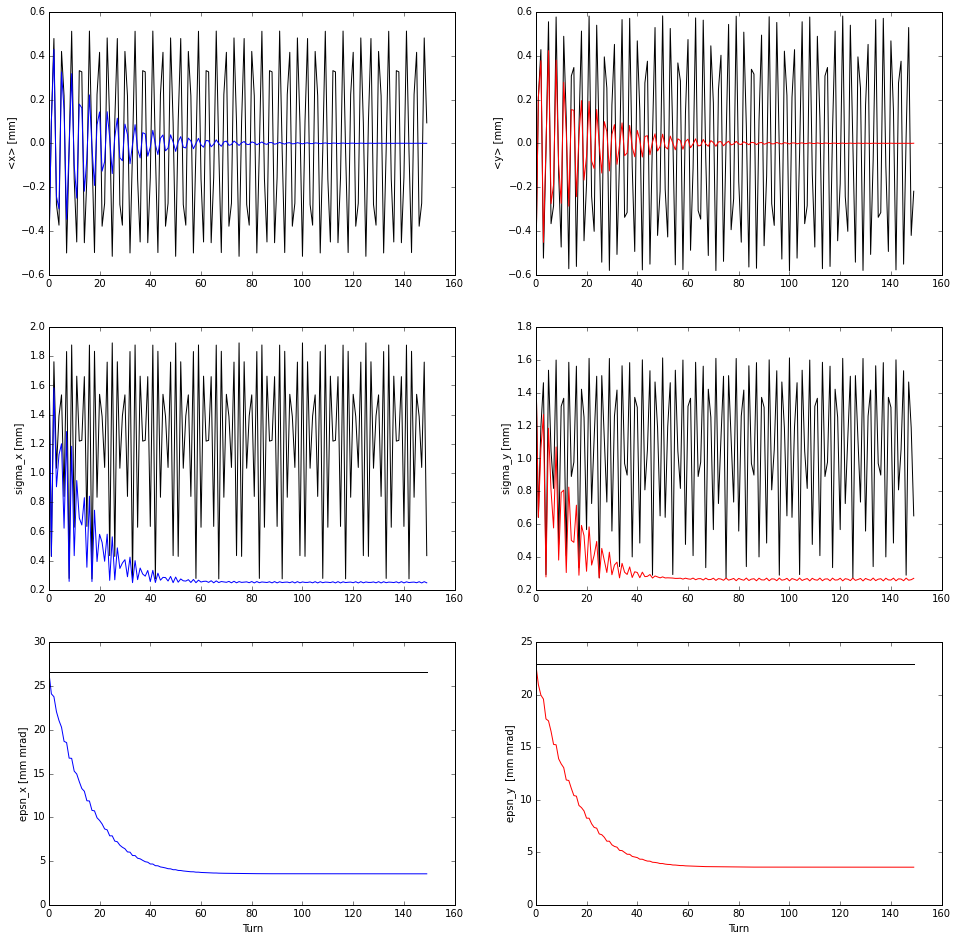

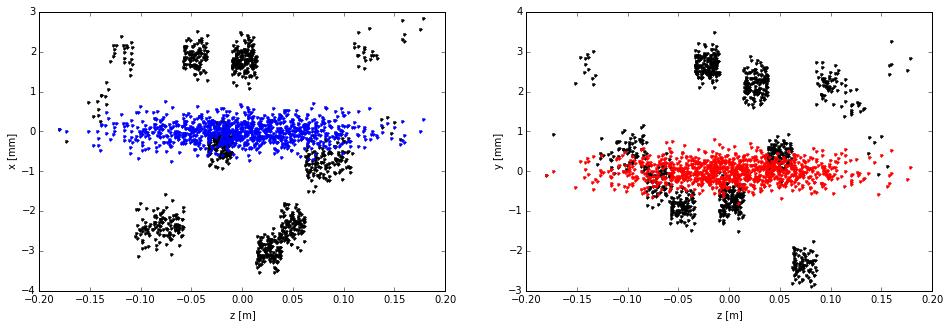

In [10]:
#Reference bunch
bunch_0 = copy.deepcopy(bunch_ref)
bunch_FB = copy.deepcopy(bunch_ref)

maps_ref = [i for i in trans_map] + [long_map]

f_cutoff = 1e10

signal_processors_x = [IdealSlice()]
signal_processors_y = [IdealSlice()]

feedback_map = OneboxFeedback(feedback_gain,slicer,signal_processors_x,signal_processors_y)
maps_feedback = [i for i in trans_map] + [long_map] + [feedback_map]

#plot_projections( bunch_0, bunch_FB)
track_and_plot(n_turns, bunch_0, maps_ref, bunch_FB, maps_feedback)
#feedback_map.print_matrix()
plot_projections( bunch_0, bunch_FB)

## Ideal bunch feedback by using general Onebox feedback

In [11]:
#Reference bunch
bunch_0 = copy.deepcopy(bunch_ref)
bunch_FB = copy.deepcopy(bunch_ref)

maps_ref = [i for i in trans_map] + [long_map]

f_cutoff = 1e10
signal_processors_x = [ChargeWeighting(),IdealBunch()]
signal_processors_y = [ChargeWeighting(),IdealBunch()]

feedback_map = OneboxFeedback(feedback_gain,slicer,signal_processors_x,signal_processors_y)
maps_feedback = [i for i in trans_map] + [long_map] + [feedback_map]

#plot_projections( bunch_0, bunch_FB)
track_and_plot(n_turns, bunch_0, maps_ref, bunch_FB, maps_feedback)
signal_processors[1].print_matrix()
plot_projections( bunch_0, bunch_FB)

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'